# Ford GoBike System
## by Mohamed Elhussien Eldessouky

## Investigation Overview

The main goal of this presentation is to investigate the trip duration and no. of trips in order to determine the most important faetures affecting these variables, as both have a direct impact on revenues, and hence affecting the marketing and sales strategies.

## Dataset Overview

The dataset has information about 1,154,202 individual rides made in Ford Gobike sharing system representing three major cities in USA (San Francisco, Boston and New York) during February 2019.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
#Importing San-Francisco dataset
df_sf = pd.read_csv('201902-fordgobike-tripdata-San Francisco.csv')
df_sf['city'] = "San Francisco"
df_sf.drop(columns='bike_share_for_all_trip', inplace=True)

#Importing Boston dataset
df_bo = pd.read_csv('201902-bluebikes-tripdata-Boston.csv')
df_bo['city'] = "Boston"
df_bo.columns = df_sf.columns

#Importing New-York dataset
df_ny = pd.read_csv('201902-citibike-tripdata-New York.csv')
df_ny['city'] = "New York"
df_ny.columns = df_sf.columns

#Concatenating the three data frames 
df = pd.concat([df_sf, df_bo, df_ny], ignore_index=True)
df.head(1)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,city
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,San Francisco


In [3]:
#Data wrangling
#Replacing 1 and 2 values to males and females & limiting gender values to males and females only
df['member_gender'].replace({1: "Male", 2: "Female"}, inplace=True)
df = df.query('member_gender == "Male" | member_gender == "Female"')

#drop null values
df.dropna(inplace=True)

#Rename birth year and gender columns
df.rename(columns={'member_birth_year': 'birth_year', 'member_gender': 'gender'}, inplace=True)

#converting three columns into integers
df[['start_station_id', 'end_station_id', 'birth_year']] = df[['start_station_id', 'end_station_id', 'birth_year']].astype('int64')

#Adding age column based on birth year column
df['age'] = 2019 - df['birth_year']

#Converting date-time columns from string to date-time format
df[['start_time', 'end_time']] = df[['start_time', 'end_time']].astype('datetime64[s]')

#Extracting hours from start date column
df['hour'] = df['start_time'].dt.hour

#Adding day of week column to determine whether the day is weekday or weekend
df['day_type'] = np.where((df['start_time'].dt.dayofweek) < 5,"weekday","weekend")

#Adding a new column for duration in minutes
df['duration_min'] = df['duration_sec'] / 60

#Adding trip type column based to categorize trips into three categories0
df['trip_type'] = np.where(df['duration_min'] < 20,"short", np.where(((df['duration_min'] > 20) & (df['duration_min'] < 60)),"moderate", "long"))

df.head(1)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,birth_year,gender,city,age,hour,day_type,duration_min,trip_type
0,52185,2019-02-28 17:32:10,2019-03-01 08:01:55,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,...,4902,Customer,1984,Male,San Francisco,35,17,weekday,869.75,long


## Trip Duration Distribution

The trip duration takes a high range of values and was highly skewed to the right, so the histogram was plotted using a logarithmic scale on x-axis where the data was found to be normally distributed around 9 minutes. Based on the distribution ranges, the trips were categorized into short trips (below 20 minutes), moderate trips (more than 20 minutes and less than 1 hour) and finally long trips (more than 1 hour).

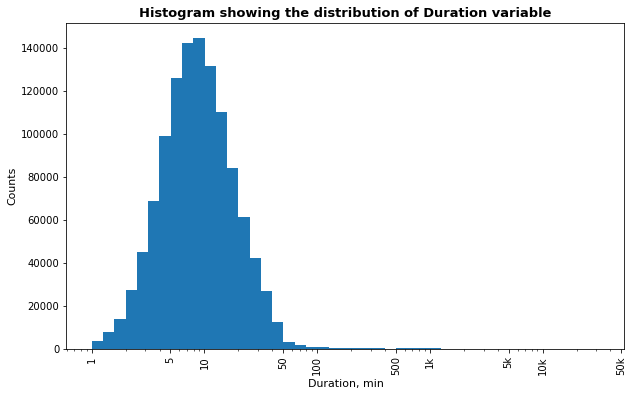

In [4]:
#Platting duration distribution after changing x-axis scale to logarithmic scale
plt.figure(figsize=[10, 6])
plt.xscale('log')
min_min = np.log10(df['duration_min'].min())
max_min = np.log10(df['duration_min'].max())
bins = 10 ** np.arange(0.001, max_min+0.01,0.1)
labels = [1,5,10,50,100,500,1000,5000,10000,50000]
labels_str = ['1','5','10','50','100','500','1k','5k','10k','50k']
plt.hist(df['duration_min'], bins=bins)
plt.xticks(labels, labels_str, rotation=90)
plt.title('Histogram showing the distribution of Duration variable',fontsize=13, fontweight='bold')
plt.xlabel('Duration, min',fontsize=11)
plt.ylabel('Counts',fontsize=11);

## Trip Categories

The interesting thing about trip categories is that although short trips represents the majority of trips with more than 87%, the sum of trips duration represents only 58.2% of all trips duration, on the other side, moderate and long trips which represents nearly 13% of all trips, their summation of trip duration is more than 40%, consequently moderate and long trips are as important as short trips.

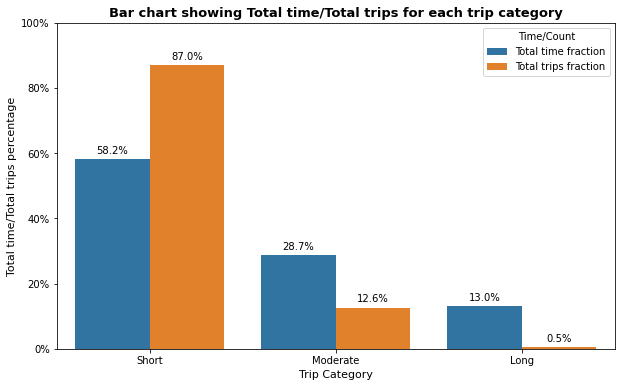

In [5]:
#Plotting a bar chart for the total trip counts and total time duration fraction for each of the three trip categories
y1 = df.query('trip_type == "short"').duration_min.sum()/df.duration_min.sum()
y2 = df.query('trip_type == "short"').shape[0]/df.shape[0]
y3 = df.query('trip_type == "moderate"').duration_min.sum()/df.duration_min.sum()
y4 = df.query('trip_type == "moderate"').shape[0]/df.shape[0]
y5 = df.query('trip_type == "long"').duration_min.sum()/df.duration_min.sum()
y6 = df.query('trip_type == "long"').shape[0]/df.shape[0]

data = {'fraction':[y1, y2, y3, y4, y5 , y6],
       'trip_type': ["Short", "Short", "Moderate", "Moderate", "Long", "Long"],
       'Time/Count':["Total time fraction", "Total trips fraction", "Total time fraction", "Total trips fraction","Total time fraction", "Total trips fraction"]}
df_duration = pd.DataFrame.from_dict(data)
plt.figure(figsize=[10, 6])
splot = sb.barplot(data = df_duration, x='trip_type', y='fraction', hue='Time/Count')
plt.xlabel('Trip Category',fontsize=11)
plt.ylabel('Total time/Total trips percentage',fontsize=11)
plt.title('Bar chart showing Total time/Total trips for each trip category',fontsize=13, fontweight='bold')
plt.yticks(np.arange(0,1.1,0.2),['0%','20%','40%','60%','80%','100%'])
for p in splot.patches: 
    splot.annotate("{0:.1%}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', xytext=(0, 9), textcoords='offset points')  

## Trips Distribution among Weekdays/Weekends

For weekdays, there is a bimodal curve observed with the first peak around 8-9 am and the second peak around 5-6 pm which matches work arrival and departure times, but for weekends, there is a complete different curve with only one peak around 2 pm with a gradual decrease before and after this time. 

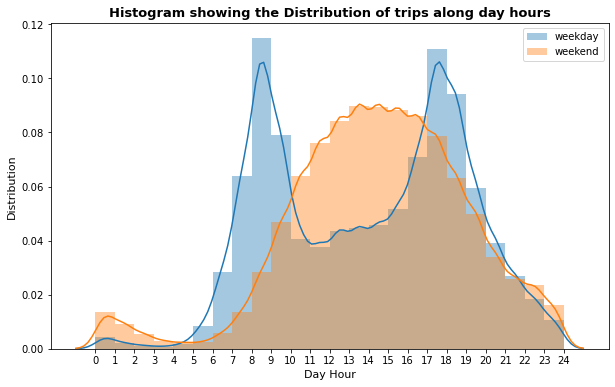

In [6]:
#plotting histogram for day hours for both weekdays and weekends
df_wd = df.query('day_type == "weekday"')
df_we = df.query('day_type == "weekend"')
bins = np.arange(0,25,1)

plt.figure(figsize=[10, 6])
sb.distplot(df_wd['hour']+0.5, bins=bins, kde_kws = {'bw' : 0.5})
sb.distplot(df_we['hour']+0.5, bins=bins, kde_kws = {'bw' : 0.5})
plt.xticks(bins)
plt.title('Histogram showing the Distribution of trips along day hours',fontsize=13, fontweight='bold')
plt.xlabel('Day Hour',fontsize=11)
plt.ylabel('Distribution',fontsize=11)
plt.legend(('weekday', 'weekend'), loc=0);

## Determining The Target Segment

The heat map is very important in determining both the age of the target segment and the hours where the trips become at the peak, the main target segment in weekdays are 20-45 age employees as the map shows the peak of trips at work arrival and departure hours, while during the weekends the same 20-45 age people with the peak between 11 am to 6 pm.

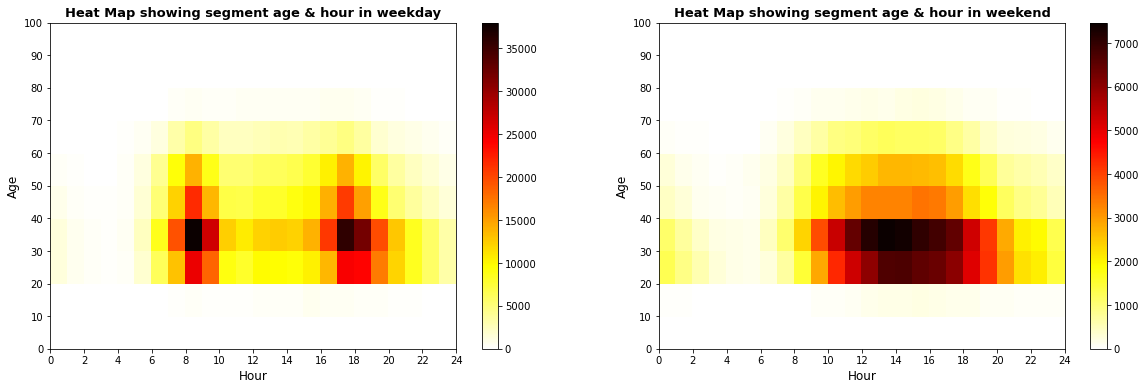

In [7]:
#Plotting a heat map for hour vs age 
plt.figure(figsize=(20,6))
bins_x = np.arange(0, 25, 1)
bins_y = np.arange(0, 110, 10)

j=1
day = df['day_type'].unique()
for var2 in day:
    plt.subplot(1,2,j)
    df_ty = df[df['day_type']==var2]
    plt.hist2d(data = df_ty, x = 'hour', y = 'age', cmap='hot_r', bins = [bins_x, bins_y])
    plt.colorbar()
    j=j+1
    plt.xticks(np.arange(0,25,2))
    plt.yticks(bins_y)
    plt.xlabel('Hour',fontsize=12)
    plt.ylabel('Age',fontsize=12)
    plt.title('Heat Map showing segment age & hour in '+var2,fontsize=13, fontweight='bold');

## Top 10 stations in each City

Here we can see the top 10 stations in each city according to the total no. of trips, where the trips are also subdivided into the three main categories to show how many trips are done in each category.

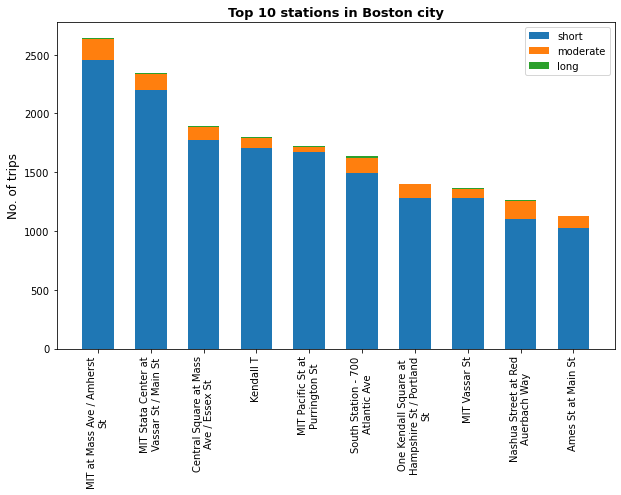

In [8]:
from textwrap import wrap
df_bo = df.query('city == "Boston"')
labels = df_bo['start_station_name'].value_counts().nlargest(10).index
df_bo_short = df_bo[df_bo.start_station_name.isin(labels)].loc[df_bo['trip_type']=="short"]
short = df_bo_short['start_station_name'].value_counts().reindex(index = labels)
df_bo_moderate = df_bo[df_bo.start_station_name.isin(labels)].loc[df_bo['trip_type']=="moderate"]
moderate = df_bo_moderate['start_station_name'].value_counts().reindex(index = labels)
df_bo_long = df_bo[df_bo.start_station_name.isin(labels)].loc[df_bo['trip_type']=="long"]
long = df_bo_long['start_station_name'].value_counts().reindex(index = labels)
width = 0.6
plt.figure(figsize=(10, 6))
plt.bar(labels, short, width, label='short')
plt.bar(labels, moderate, width, bottom=short, label='moderate')
plt.bar(labels, long, width, bottom=short+moderate, label='long')
plt.ylabel('No. of trips',fontsize=12)
plt.title('Top 10 stations in Boston city',fontsize=13, fontweight='bold')
plt.legend()
labels = ['\n'.join(wrap(l, 25)) for l in labels]
plt.xticks(np.arange(0,10,1),labels,rotation=90);

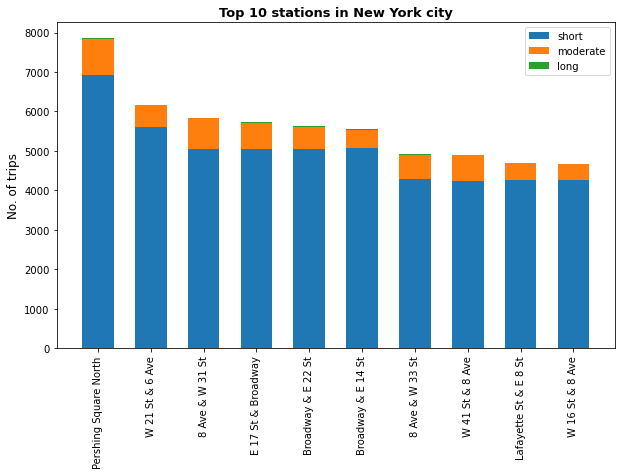

In [9]:
df_ny = df.query('city == "New York"')
labels = df_ny['start_station_name'].value_counts().nlargest(10).index
df_ny_short = df_ny[df_ny.start_station_name.isin(labels)].loc[df_ny['trip_type']=="short"]
short = df_ny_short['start_station_name'].value_counts().reindex(index = labels)
df_ny_moderate = df_ny[df_ny.start_station_name.isin(labels)].loc[df_ny['trip_type']=="moderate"]
moderate = df_ny_moderate['start_station_name'].value_counts().reindex(index = labels)
df_ny_long = df_ny[df_ny.start_station_name.isin(labels)].loc[df_ny['trip_type']=="long"]
long = df_ny_long['start_station_name'].value_counts().reindex(index = labels)
width = 0.6
plt.figure(figsize=(10, 6))
plt.bar(labels, short, width, label='short')
plt.bar(labels, moderate, width, bottom=short, label='moderate')
plt.bar(labels, long, width, bottom=short+moderate, label='long')
plt.ylabel('No. of trips',fontsize=12)
plt.title('Top 10 stations in New York city',fontsize=13, fontweight='bold')
plt.legend()
plt.xticks(rotation=90);

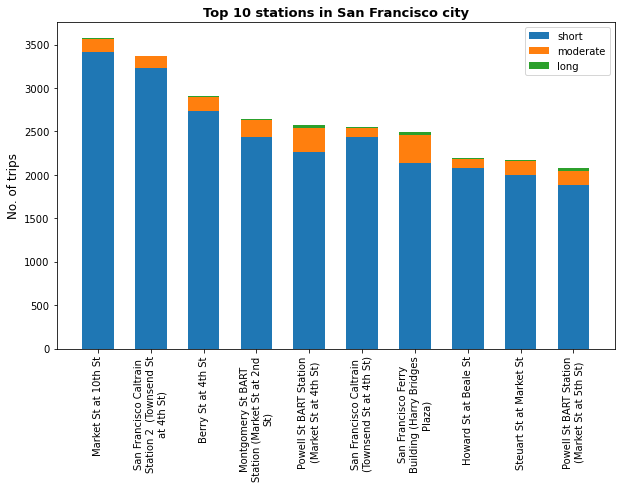

In [10]:
from textwrap import wrap
df_sf = df.query('city == "San Francisco"')
labels = df_sf['start_station_name'].value_counts().nlargest(10).index
df_sf_short = df_sf[df_sf.start_station_name.isin(labels)].loc[df_sf['trip_type']=="short"]
short = df_sf_short['start_station_name'].value_counts().reindex(index = labels)
df_sf_moderate = df_sf[df_sf.start_station_name.isin(labels)].loc[df_sf['trip_type']=="moderate"]
moderate = df_sf_moderate['start_station_name'].value_counts().reindex(index = labels)
df_sf_long = df_sf[df_sf.start_station_name.isin(labels)].loc[df_sf['trip_type']=="long"]
long = df_sf_long['start_station_name'].value_counts().reindex(index = labels)
width = 0.6
plt.figure(figsize=(10, 6))
plt.bar(labels, short, width, label='short')
plt.bar(labels, moderate, width, bottom=short, label='moderate')
plt.bar(labels, long, width, bottom=short+moderate, label='long')
plt.ylabel('No. of trips',fontsize=12)
plt.title('Top 10 stations in San Francisco city',fontsize=13, fontweight='bold')
plt.legend()
labels = ['\n'.join(wrap(l, 25)) for l in labels]
plt.xticks(np.arange(0,10,1),labels,rotation=90);